In [ ]:
#| default_exp vision.augment

In [ ]:
#| export
from __future__ import annotations

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastai.vision.all import *
from fastgs.vision.core import *

# Vision augmentation

> Augmentation support for MSTensorImage and TensorMask

We use the albumentations library to provide mult-spectral augmentations.

Because of the way albumentations works with masks, we have to transform image and mask together. In order to do this we have to subclass `ItemTransform` instead of `RandTransform`.

Unlike `RandTransform`, `ItemTransform` cannot be easily parameterized to work on both training and validation sets, so we need to create multiple classes (which are identical, except for the `split_idx`) to cover all cases.

We use python meta-programming to keep things DRY.

To begin we have a simple fastai style constructor

In [ ]:
#| export
def _ms_seg_alb_xfm_init(self, aug): store_attr()

We then create an encoder that calls the albumentations transform, converting back and forth from the type/shape expected by albumentations.

In [ ]:
#| export
def _ms_seg_alb_xfm_encodes(self, x):
    img,msk = x
    res = self.aug(image=img.permute(1,2,0).numpy(),mask=msk.numpy())
    return (
        TensorImageMS.from_tensor(torch.from_numpy(res["image"]).permute(2,0,1),bands=img.bands,captions=img.captions,brgtX=img.brgtX),
        TensorMask(torch.from_numpy(res["mask"]))
    )

Finally, a function that dynamically constructs the transform class with the specified `split_idx` (0 for training, 1 for validation, and None for testing)

In [ ]:
#| export
def _create_ms_seg_alb_xfm_cls(clsname, split_idx):
    return type(
        clsname,
        (ItemTransform,),
        {
            "split_idx": split_idx,
            "__init__": _ms_seg_alb_xfm_init,
            "encodes": _ms_seg_alb_xfm_encodes
        }
    )

Let's see if this works. First we need to create a class `TestMSSAT` which will work outside the pipeline.

In [ ]:
TestMSSAT = _create_ms_seg_alb_xfm_cls("TestMSSAT", None)

First create a transform using a simple albumentations transform

In [ ]:
import albumentations as A

In [ ]:
tfm = TestMSSAT(A.HorizontalFlip(p=1))

Next we load our sample img / msk tuple using the test fixture function.

In [ ]:
from fastgs.test.fixture import *

In [ ]:
(img_org,msk_org) = get_11b_test_tuple()

Let's perform the transform

In [ ]:
(img_tfm,msk_tfm) = tfm((img_org,msk_org))

Here is the original image

[<AxesSubplot:title={'center':'B04,B03,B02'}>,
 <AxesSubplot:title={'center':'B07,B06,B05'}>,
 <AxesSubplot:title={'center':'B12,B11,B8A'}>,
 <AxesSubplot:title={'center':'B08'}>]

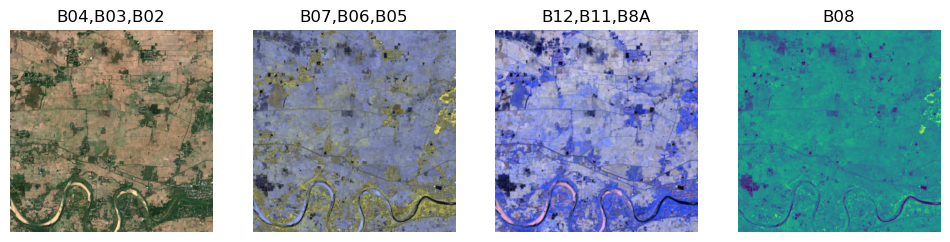

In [ ]:
img_org.show()

and the transformed image

[<AxesSubplot:title={'center':'B04,B03,B02'}>,
 <AxesSubplot:title={'center':'B07,B06,B05'}>,
 <AxesSubplot:title={'center':'B12,B11,B8A'}>,
 <AxesSubplot:title={'center':'B08'}>]

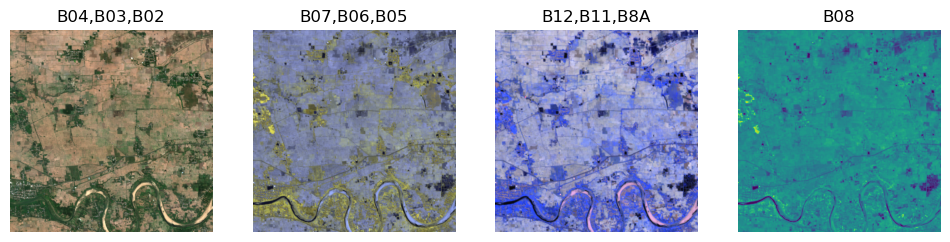

In [ ]:
img_tfm.show()

and the horizontal flip has worked as it is supposed to

We check the masks to see that the transform worked as advertised

<AxesSubplot:>

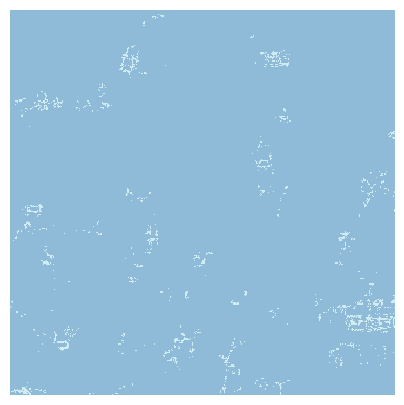

In [ ]:
msk_org.show()

<AxesSubplot:>

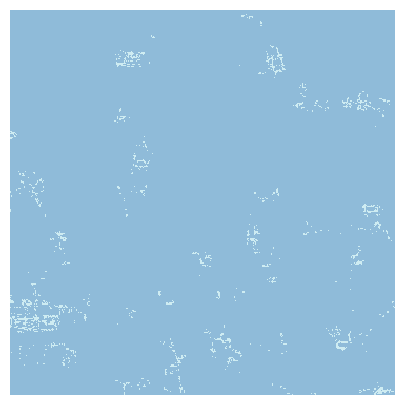

In [ ]:
msk_tfm.show()

Finally, we create the classes for training and validation

In [ ]:
#| export
TrainMSSAT = _create_ms_seg_alb_xfm_cls("TrainMSSAT", 0)
ValidMSSAT = _create_ms_seg_alb_xfm_cls("ValidMSSAT", 1)

In [ ]:
from fastgs.test.fixture import *
from fastgs.vision.data import *
from fastgs.multispectral import *

In [ ]:
fgs = get_11b_test_fgs(
    MSAugment(
        train_aug=A.ShiftScaleRotate(p=1),
        valid_aug=A.Rotate(p=1)
    )
)
dl = fgs.create_data_block().dataloaders(source=[66]*10,bs=8)

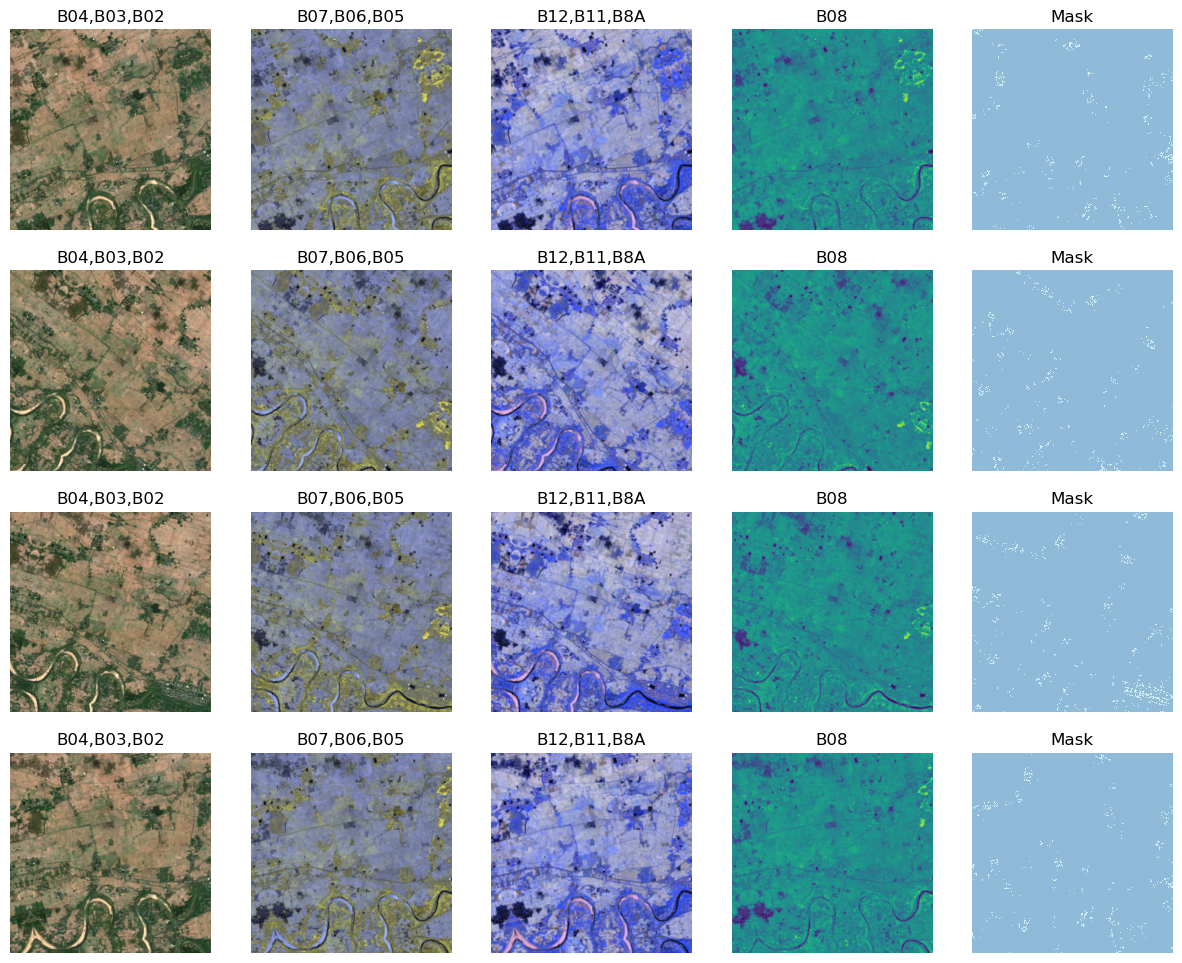

In [ ]:
dl.train.show_batch(max_n=4,mskovl=False)

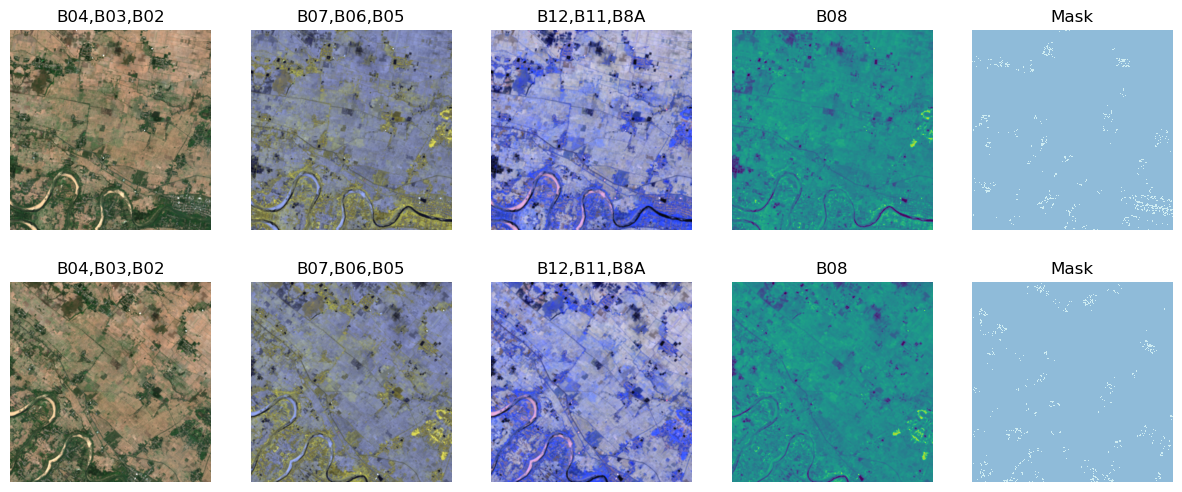

In [ ]:
dl.valid.show_batch(mskovl=False)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()